## Phase 3: Escaping the Notebook

So far we have been running everything in the notebook. Our final Dash app however will be a Python app that runs independantly of Jupyter. In order to migrate our code out of the notebook while trying to minimise the tech debt that we introduce, we will do the following two things:

1. Wrap up our code into a unifying abstraction that looks after the following responsibiilties:
 * Loading and saving data
 * Filter data
 * Make custom plots from filtered data
2. Convert this code into a package (a hot tip)

Step 1 will provide us with a convenient interface for working with the pedestrain data that has been tailored to the activities we require. This will allow us to keep the code of our dashboard cleaner 

This cusatom API for working with the pedestrian dataset will also.


gives you tools for performing later analysis faster and will 

#### __*Hot Tip:*__ Convert your project into a package

```
Wrapping your package up into a package provides a number of useful benefits. 
```

1. You can import from your package anywhere, including both Python modules and Jupyter Notebooks. This frees you up from having to keep your Python modules living in the same directory as your notebooks (or messing around with PYTHONPATH, which is often a sign you're heading in the wrong direction).

2. Any command line scripts you have in your project can be easily inserted into the PATH of your virtualenv. 


Let's install the `melbviz` package as an _editable_ install. 

An editable installation means that changes you make to the package code will be reflecrted in the package when you import it. This is contrasted with the default install, which takes a snapshot of the package code at install time.

Make sure you are in the same directory as Melbviz's setup.py before running the following on your command line, and then restart this kernel:

```
pip install -e .
```

### The `PedestrianDataset` class

In [13]:
%load_ext autoreload
%autoreload 2

from melbviz.pedestrian import PedestrianDataset
from melbviz.config import MELBVIZ_DATA_PATH, MELBVIZ_COUNTS_CSV_PATH, MELBVIZ_SENSOR_CSV_PATH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# loading and cleaning

data = PedestrianDataset.load(MELBVIZ_COUNTS_CSV_PATH, sensor_csv_path=MELBVIZ_SENSOR_CSV_PATH)
data.df.head()

,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts,Location_ID,Latitude,Longitude
2716053,2009-05-01,2009,May,1,Friday,0,6,Flinders Street Station Underpass,139,6,-37.819117,144.965583
1704860,2009-05-01,2009,May,1,Friday,0,1,Bourke Street Mall (North),53,1,-37.813494,144.965153
2601053,2009-05-01,2009,May,1,Friday,0,5,Princes Bridge,157,5,-37.818742,144.967877
2274574,2009-05-01,2009,May,1,Friday,0,11,Waterfront City,5,11,-37.815650,144.939707
1586737,2009-05-01,2009,May,1,Friday,0,2,Bourke Street Mall (South),52,2,-37.813807,144.965167


In [15]:
# filtering

sensors = ["Lygon St (East)", "Lygon St (West)", "Faraday St-Lygon St (West)"]
new_data = data.filter(year=2020, month="March", sensor=sensors)
new_data.df.shape

(2232, 12)

In [16]:
# the filter method returns another PedestrianDataset so you can chain filters

data.filter(year=2020).filter(month="March").filter(sensor=sensors).df.shape

(2232, 12)

In [17]:
# has convenience properties

(new_data.years, new_data.months, new_data.sensors)

([2020],
 ['March'],
 ['Faraday St-Lygon St (West)', 'Lygon St (East)', 'Lygon St (West)'])

In [18]:
new_data.available_plots

['sensor_counts',
 'month_counts',
 'sensor_traffic',
 'year_traffic',
 'sensor_map',
 'stacked_sensors']

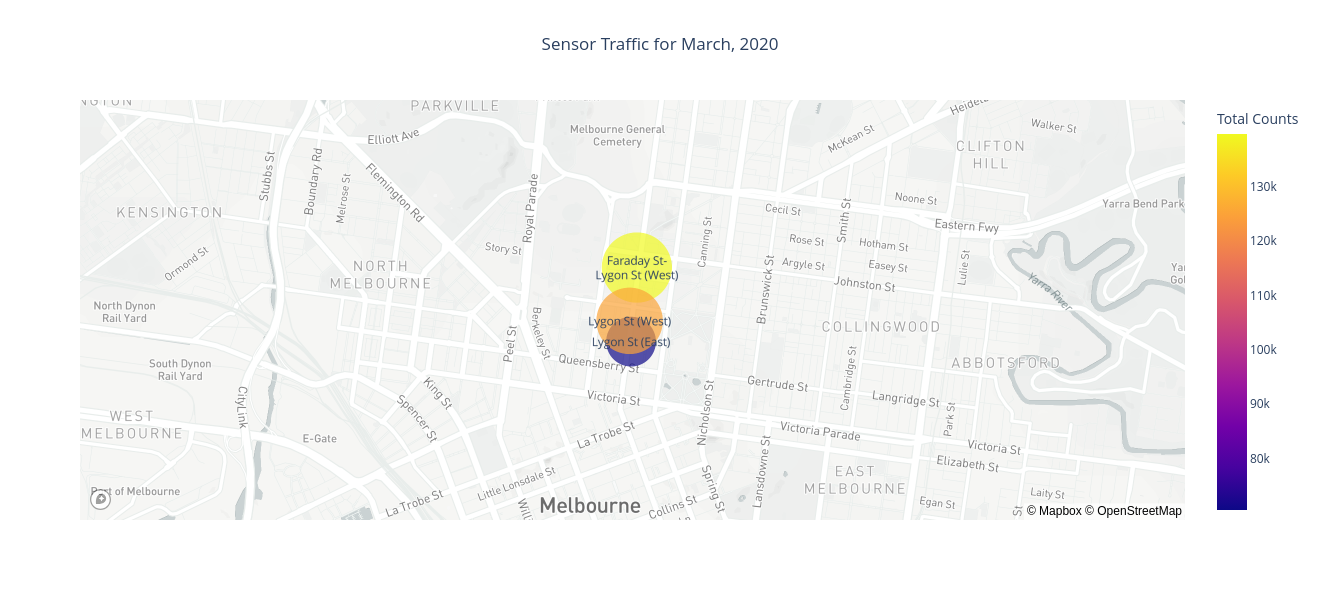

In [21]:
new_data.plot("sensor_map", height=600)

#### __*Hot Tip:*__ Save cleaned data in Parquet format

When you've applied a bunch of cleaning to a large CSV file, I reccomend saving it in a binary dataframe format such as Parquet or Arrow, rather than saving it to a CSV file. These have the following advantages:

 * The data schema is contained within the file. This is often referred to as _schema-on-write_ (as opposed to _schema-on-read_), which means that you don't have to worry about getting the Pandas column `dtypes` right as there's no deserialisation to do.
 * It's compressed, so takes up less space on disk than CSV.
 * It's a columnar format, which is well suited to large-scale analytics style queries, and so is supported by tools like Presto (AWS Athena).


In [ ]:
data.to_parquet(MELBVIZ_DATA_PATH / "melbviz.parquet")

## Phase 4: Making the Dashboard

### Dash

Dash tutorial link:



### Layout
* HTML components
* Dash Core Components
* Custom React-based Components

### Callbacks

* syntax and how they work
* callbacks are stateless 

### Walkthough the Dashboard

## Phase 5: Deploying the Dashboard

### Demo Server

### Using a WGI Server for Production

### Scaling Out orizontally 


#### __*Hot Tip:*__ Use a Web server as well as a WSGI Server

```
Using a WSGU server such as Gunicorn alone, can leave you vulnerable you to denial of service attacks, as requests will come in to your worker processes unbuffered, and could potentially choke the app. If reliability is a concern you should make sure to use a buffering web server such as Nginx or Apache.
```

In [ ]:
def plot_sensor_traffic(df, same_yscale=False, row_height=150, limit=5):
    """Plot hourly traffic for one or more sensors"""
    target_sensors = (
        df.groupby("Sensor_Name")["Hourly_Counts"].sum().sort_values(ascending=False)
    )[:limit]
    df = df[df["Sensor_Name"].isin(set(target_sensors.index))]

    figure = px.line(
        df,
        y="Hourly_Counts",
        x="Date_Time",
        facet_row="Sensor_Name",
        title="Hourly Pedestrian Traffic by Sensor",
        category_orders={"Sensor_Name": list(target_sensors.index)},
    )

    figure.update_layout(title_x=0.5)
    figure.update_yaxes(
        matches=None if same_yscale else "y",
        showgrid=False,
        zeroline=False,
        title_text=None,
    )
    figure.update_xaxes(showgrid=True, title_text=None)
    figure.for_each_annotation(
        lambda a: a.update(textangle=0, text=a.text.split("=")[-1])
    )
    return figure